In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# mount the google drive
from google.colab import drive
drive.mount("/content/drive/")

path_to_files = "/content/drive/MyDrive/MachineLearning/lab_1/"
output_dir = "/content/drive/MyDrive/MachineLearning/lab_1/outpus/"

Mounted at /content/drive/


## Test the initial accuraty without any feature selection

 - With RandomForest classifier
 - Parameters are n_estimators=100 and the random_state=42

In [3]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

In [4]:
# read data
train = pd.read_csv(path_to_files + "train.csv")
validation = pd.read_csv(path_to_files + "valid.csv")

In [5]:
# drop label_2, label_3 and label_4
dropping_labels = ["label_2","label_3", "label_1"]
train = train.drop(dropping_labels, axis=1)
validation = validation.drop(dropping_labels, axis=1)

In [6]:
# check whether any missing values in the train set
train.columns[train.isnull().any()]

Index([], dtype='object')

In [7]:
# splitting features and the label
x_train = train.drop(["label_4"], axis=1)
y_train = train["label_4"]
x_test = validation.drop(["label_4"], axis=1)
y_test = validation["label_4"]

In [8]:
# Initializing the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier on the training data
rf_classifier.fit(x_train, y_train)

# Making predictions on the testing data
y_pred = rf_classifier.predict(x_test)

# Calculating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.844


## Step 1 : Handing Missing Values

In [9]:
# check whether any missing values in train or validation sets
print("Columns with missing values in train set: ",train.columns[train.isnull().any()])
print("Columns with missing values in validation set: ",validation.columns[validation.isnull().any()])

Columns with missing values in train set:  Index([], dtype='object')
Columns with missing values in validation set:  Index([], dtype='object')


## 02. Using the variance threshould method

In [10]:
# check for minimum variance
print("Minimum variance found is: ",x_train.describe().loc['std'].min()**2)

Minimum variance found is:  0.6658927361784652


Since the minimum variance is 0.6658, no need of using variance threshould method

## 03. Using Corellation

In [11]:
# The bellow function returns all the co-related features
def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j])>= threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [12]:
correlation(x_train, 0.85)

set()

The function returns empty set, that means no highly co-related values in the dataset.

## Step 4: Scalling

In [13]:
# define the scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit the scaler
sx_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
sx_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

## Step 5: Feature Importance

In [14]:
# Initializing the Random Forest classifier
rfi_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier on the training data
rfi_classifier.fit(x_train, y_train)

# Making predictions on the testing data
y_pred = rfi_classifier.predict(x_test)

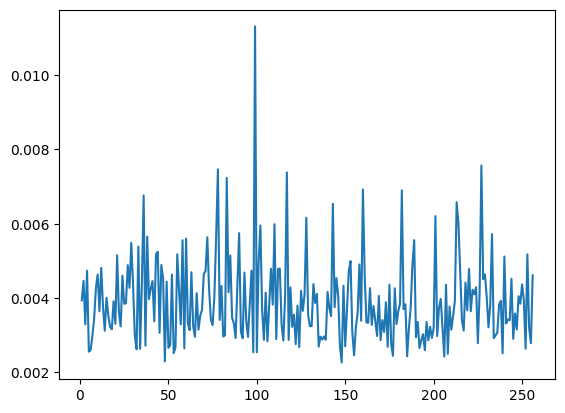

In [15]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(1,len(rfi_classifier.feature_importances_)+1)] ,rfi_classifier.feature_importances_)

In [17]:
def getDroppingFields(feature_importances, threshold):
  dropping_labels = []
  for i in range(len(feature_importances)):
    if feature_importances[i]<=threshold:
      dropping_labels.append(f"feature_{i+1}")
  return dropping_labels

should_dropped = getDroppingFields(rfi_classifier.feature_importances_, 0.0032)
print(f"Dropping {len(should_dropped)} features")

rsx_train = sx_train.drop(should_dropped, axis=1)
rsx_test = sx_test.drop(should_dropped, axis=1)

Dropping 76 labels


## Step 6: Principal Component Analysis

In [44]:
# define the pca
from sklearn.decomposition import PCA
pca = PCA(n_components=60)

prsx_train = pca.fit_transform(rsx_train)
prsx_test = pca.transform(rsx_test)

## Step 7: Classification while handling imbalances in the Dataset

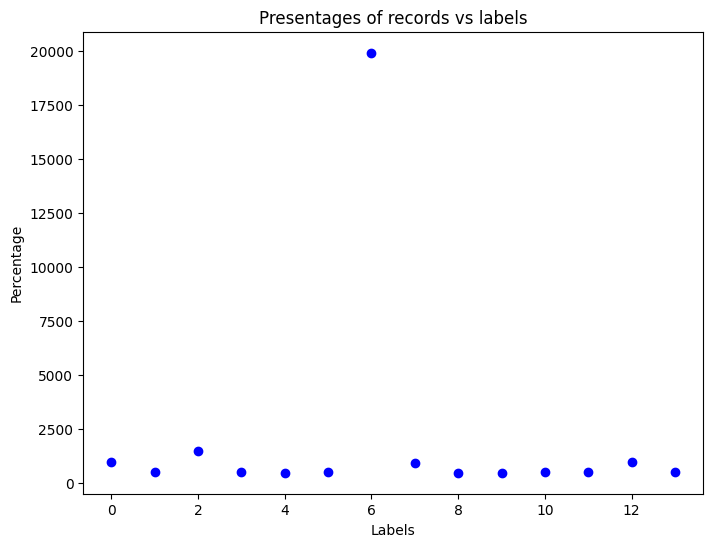

In [45]:
label_counts = train['label_4'].value_counts()
tot_records = len(train)
percentages = {}
for index, count in label_counts.items():
  percentages[index] = count

lbls = []
ptages = []
for key, value in sorted(percentages.items()):
  lbls.append(key)
  ptages.append(value)

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size (width, height)

plt.scatter(lbls, ptages, color='blue', marker='o', label='Data Points')  # Create scatter plot
plt.title('Presentages of records vs labels')  # Set the title of the plot
plt.xlabel('Labels')  # Set the label for the x-axis
plt.ylabel('Percentage')  # Set the label for the y-axis

plt.show()  # Display the plot

Since there is no category with higher presentage of data. Dataset is not a imbalance one. Hense no need of handling imbalances.

In [46]:
percentages[6] = 2500

In [47]:
from imblearn.under_sampling import RandomUnderSampler

# define undersampler
undersampler = RandomUnderSampler(sampling_strategy=percentages)

# Apply the undersampling to your training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(prsx_train, y_train)

# Initializing the Random Forest classifier
prf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier on the training data
prf_classifier.fit(X_train_resampled, y_train_resampled)

# Making predictions on the testing data
prsy_pred = prf_classifier.predict(prsx_test)

# Calculating the accuracy of the classifier
accuracy = accuracy_score(y_test, prsy_pred)
print("Accuracy:", accuracy)

Accuracy: 0.96


## Creation of submision *csv* file

In [48]:
# load test dataset
f_test = pd.read_csv(path_to_files + "test.csv")
f_test = f_test.drop(['label_1','label_2','label_3','label_4'], axis=1)

# label prediction before feature selection
label4_pred_before = rf_classifier.predict(f_test)

# label prediction after feature selection
df_test = f_test.drop(should_dropped, axis=1)
pdf_test = pca.transform(df_test)

label4_pred_after = prf_classifier.predict(pdf_test)

In [49]:
pred_df = pd.DataFrame(label4_pred_before, columns=['Predicted labels before feature engineering'])
pred_df['Predicted labels after feature engineering'] = label4_pred_after
pred_df['No of new features'] = pdf_test.shape[1]

features_df = pd.DataFrame(pdf_test, columns=[f"new_feature_{i}" for i in range(1, pdf_test.shape[1]+1)])
submition_df = pd.concat([pred_df,features_df], axis=1)
submition_df.head()

,Predicted labels before feature engineering,Predicted labels after feature engineering,No of new features,new_feature_1,new_feature_2,new_feature_3,new_feature_4,new_feature_5,new_feature_6,new_feature_7,...,new_feature_51,new_feature_52,new_feature_53,new_feature_54,new_feature_55,new_feature_56,new_feature_57,new_feature_58,new_feature_59,new_feature_60
0,6,6,60,1.890519,5.309171,-3.661594,4.754870,-5.634972,4.715159,-1.406849,...,-0.941034,-1.134246,2.231897,0.886484,0.834968,1.178493,-1.456241,-0.799887,-1.251714,1.398244
1,6,6,60,-1.619346,9.866579,-3.760909,10.793050,2.332765,6.367945,2.353493,...,0.368222,-1.153250,0.626120,1.350874,1.137248,0.307578,-1.799521,-1.543727,0.029472,0.410060
2,6,6,60,-2.183550,3.713155,-3.580779,8.140829,0.610117,0.334675,0.537651,...,0.307877,-1.351811,1.999002,2.357882,0.836172,-0.377120,-0.928690,-2.461094,-0.248529,-0.002847
3,6,6,60,1.633065,5.596581,-2.995964,2.488846,3.240847,0.444036,4.013361,...,-0.253685,-1.674647,2.589063,0.867721,0.440425,-0.042236,-0.509232,-0.686149,0.943131,0.992789
4,6,6,60,4.236318,4.255402,-2.163839,7.462799,-1.019472,2.624157,-0.480794,...,-0.884752,-0.580437,2.658002,1.439965,1.001847,0.492472,-2.240856,-1.325706,0.129957,1.072451


In [51]:
submition_df.to_csv(output_dir+"190438H_label_4.csv",index = False)

In [50]:
len(submition_df[submition_df['Predicted labels before feature engineering']==submition_df['Predicted labels after feature engineering']])/len(submition_df)*100

86.13333333333333